# Pruning Convolutional Neural Network


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torchvision
import torch.nn.utils.prune as prune
import torch.nn.utils.prune as prune_utils
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, random_split
from torchvision.datasets import CIFAR10
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import copy
from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import seaborn as sns
sns.set(style="whitegrid")
from sklearn.metrics import accuracy_score

In [ ]:
base_path = "/content/drive/MyDrive/Colab Notebooks/Hardware_AI/CA2"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Download CIFAR10 Dataset and make data loaders

In [ ]:
trainset_raw = CIFAR10(root= base_path+'/train', train=True, download=True)

testset_raw = CIFAR10(root= base_path +'/test', train=False, download=True)

100%|██████████| 170M/170M [03:06<00:00, 915kB/s]
100%|██████████| 170M/170M [01:07<00:00, 2.53MB/s]


In [5]:
imgs = torch.stack([torch.tensor(np.array(img)).permute(2, 0, 1) / 255.0 for img, _ in trainset_raw], dim=0)

mean = imgs.mean(dim=(0, 2, 3))
std = imgs.std(dim=(0, 2, 3))

print(f"Mean: {mean}")
print(f"Std:  {std}")

Mean: tensor([0.4914, 0.4822, 0.4465])
Std:  tensor([0.2470, 0.2435, 0.2616])


In [6]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

val_test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

train_val_ratio = 0.9

train_size = int(train_val_ratio * len(trainset_raw))
val_size = len(trainset_raw) - train_size
generator = torch.Generator().manual_seed(42)
train_subset, val_subset = random_split(trainset_raw, [train_size, val_size], generator=generator)

train_subset.dataset.transform = train_transform
val_subset.dataset.transform = val_test_transform

testset = datasets.CIFAR10(root=base_path + '/test', train=False, download=True, transform=val_test_transform)

train_loader = DataLoader(train_subset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=256, shuffle=False)
test_loader = DataLoader(testset, batch_size=256, shuffle=False)

print(f"Train samples: {len(train_subset)}")
print(f"Validation samples: {len(val_subset)}")
print(f"Test samples: {len(testset)}")

Train samples: 45000
Validation samples: 5000
Test samples: 10000


## Define Model

In [7]:
class CNNModel(nn.Module):
    def __init__(self, num_classes=10):
        super(CNNModel, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.25),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.25),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.25),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [8]:
def train_model(model, train_loader, val_loader, num_epochs=50, patience=7, device='cuda'):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

    best_val_loss = float('inf')
    best_model_state = None
    early_stop_counter = 0

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        train_loss, correct, total = 0.0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        avg_train_loss = train_loss / total
        train_acc = correct / total

        # Validation
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        avg_val_loss = val_loss / total
        val_acc = correct / total

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | "
              f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict()
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print("Early stopping triggered.")
                break

        scheduler.step(avg_val_loss)

    model.load_state_dict(best_model_state)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss Over Epochs")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label="Train Accuracy")
    plt.plot(val_accuracies, label="Val Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Over Epochs")
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model


## Unstructured pruning

### 1: Oneshot Pruning

#### Implementation:

In [9]:
def apply_unstructured_pruning(model, amount):
    model_copy = copy.deepcopy(model)
    for name, module in model_copy.named_modules():
        if isinstance(module, torch.nn.Conv2d) or isinstance(module, torch.nn.Linear):
            prune.l1_unstructured(module, name='weight', amount=amount)
            prune.remove(module, 'weight')
    return model_copy

def count_nonzero_param_size_MB(model):
    total_nonzero = 0
    for param in model.parameters():
        if param.requires_grad:
            total_nonzero += torch.count_nonzero(param).item()
    size_MB = total_nonzero * 4 / (1024 ** 2)
    return size_MB, total_nonzero


def evaluate(model, dataloader, device='cuda'):
    model.eval()
    model.to(device)
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
    return accuracy_score(all_labels, all_preds)

#### Results:

In [ ]:
model = CNNModel()
model.load_state_dict(torch.load(base_path + "/cnn_model.pth"))
model.eval()

base_acc = evaluate(model, test_loader)
base_size_MB, base_params = count_nonzero_param_size_MB(model)

print(f"Base Model: Accuracy: {base_acc * 100:.2f}% | Size: {base_size_MB:.2f} MB | Parameters: {base_params}")

prune_percentages = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

for amount in prune_percentages:
    pruned_model = apply_unstructured_pruning(model, amount)
    acc = evaluate(pruned_model, test_loader)
    size_MB, pruned_params = count_nonzero_param_size_MB(pruned_model)

    print(f"Pruned {int(amount * 100)}% → Accuracy: {acc * 100:.2f}% | Size: {size_MB:.2f} MB | Params: {pruned_params}")


Base Model: Accuracy: 88.44% | Size: 4.53 MB | Parameters: 1188170
Pruned 20% → Accuracy: 88.31% | Size: 3.63 MB | Params: 951075
Pruned 30% → Accuracy: 87.81% | Size: 3.18 MB | Params: 832529
Pruned 40% → Accuracy: 86.98% | Size: 2.72 MB | Params: 713981
Pruned 50% → Accuracy: 82.99% | Size: 2.27 MB | Params: 595434
Pruned 60% → Accuracy: 71.11% | Size: 1.82 MB | Params: 476887
Pruned 70% → Accuracy: 40.35% | Size: 1.37 MB | Params: 358339
Pruned 80% → Accuracy: 13.69% | Size: 0.91 MB | Params: 239793


### 2: Step-by-step training

#### Implementation:

In [10]:
def apply_incremental_pruning(model, amount):
    for module in model.modules():
        if isinstance(module, torch.nn.Conv2d) or isinstance(module, torch.nn.Linear):
            prune.l1_unstructured(module, name='weight', amount=amount)

In [11]:
def count_nonzero_param_size_step(model):
    total_nonzero = 0
    for module in model.modules():
        if isinstance(module, (torch.nn.Conv2d, torch.nn.Linear)):
            if hasattr(module, 'weight_mask'):
                total_nonzero += torch.count_nonzero(module.weight_mask).item()
            else:
                total_nonzero += torch.count_nonzero(module.weight).item()
    size_MB = total_nonzero * 4 / (1024 ** 2)
    return size_MB, total_nonzero


In [ ]:
model = CNNModel()
model.load_state_dict(torch.load(base_path + "/cnn_model.pth"))
model.eval()

CNNModel(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.25, inplace=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Dropout(p=0.25, i

#### Results:

Base Model: Accuracy: 88.44% | Size: 4.52 MB | Parameters: 1185472

Applying 20% cumulative pruning:


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/10 | Train Loss: 0.0587 | Val Loss: 0.5038 | Train Acc: 0.9815 | Val Acc: 0.8626
Epoch 2/10 | Train Loss: 0.0926 | Val Loss: 0.4673 | Train Acc: 0.9684 | Val Acc: 0.8664
Epoch 3/10 | Train Loss: 0.0881 | Val Loss: 0.4818 | Train Acc: 0.9703 | Val Acc: 0.8644
Epoch 4/10 | Train Loss: 0.0815 | Val Loss: 0.4748 | Train Acc: 0.9732 | Val Acc: 0.8688
Epoch 5/10 | Train Loss: 0.0794 | Val Loss: 0.4649 | Train Acc: 0.9738 | Val Acc: 0.8684
Epoch 6/10 | Train Loss: 0.0680 | Val Loss: 0.4861 | Train Acc: 0.9786 | Val Acc: 0.8660
Epoch 7/10 | Train Loss: 0.0679 | Val Loss: 0.4600 | Train Acc: 0.9779 | Val Acc: 0.8680
Epoch 8/10 | Train Loss: 0.0666 | Val Loss: 0.4530 | Train Acc: 0.9787 | Val Acc: 0.8680
Epoch 9/10 | Train Loss: 0.0668 | Val Loss: 0.5468 | Train Acc: 0.9776 | Val Acc: 0.8572
Epoch 10/10 | Train Loss: 0.0645 | Val Loss: 0.4377 | Train Acc: 0.9790 | Val Acc: 0.8796


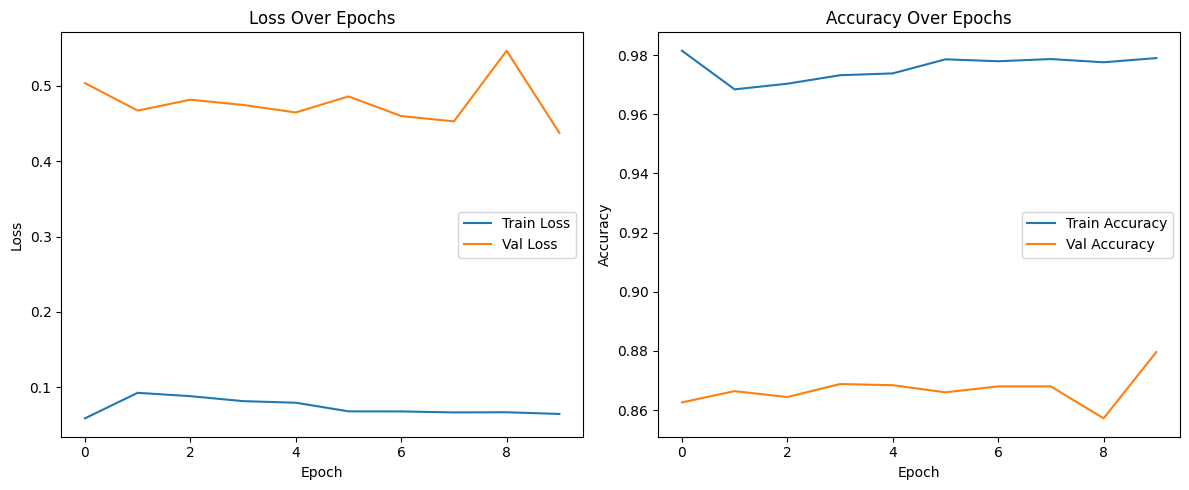

Pruned 20% : Accuracy: 86.80% | Size: 4.07 MB | Params: 1066925

Applying 30% cumulative pruning:


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/10 | Train Loss: 0.0518 | Val Loss: 0.4792 | Train Acc: 0.9843 | Val Acc: 0.8700
Epoch 2/10 | Train Loss: 0.0505 | Val Loss: 0.4537 | Train Acc: 0.9845 | Val Acc: 0.8710
Epoch 3/10 | Train Loss: 0.0511 | Val Loss: 0.4722 | Train Acc: 0.9839 | Val Acc: 0.8718
Epoch 4/10 | Train Loss: 0.0466 | Val Loss: 0.4409 | Train Acc: 0.9860 | Val Acc: 0.8756
Epoch 5/10 | Train Loss: 0.0460 | Val Loss: 0.4664 | Train Acc: 0.9858 | Val Acc: 0.8712
Epoch 6/10 | Train Loss: 0.0471 | Val Loss: 0.4599 | Train Acc: 0.9855 | Val Acc: 0.8728
Epoch 7/10 | Train Loss: 0.0451 | Val Loss: 0.4528 | Train Acc: 0.9864 | Val Acc: 0.8688
Early stopping triggered.


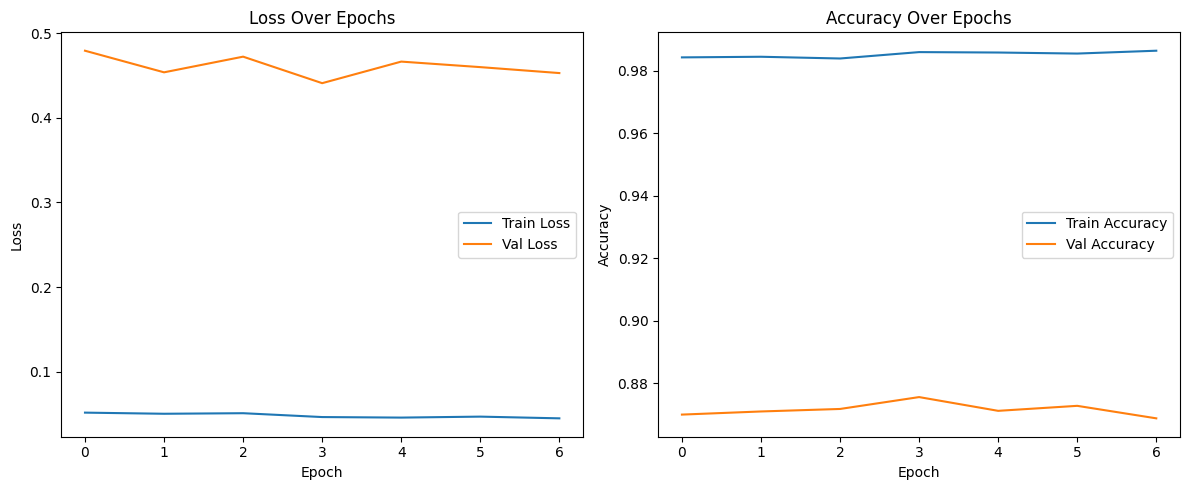

Pruned 30% : Accuracy: 86.82% | Size: 3.66 MB | Params: 960232

Applying 40% cumulative pruning:


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/10 | Train Loss: 0.0398 | Val Loss: 0.4492 | Train Acc: 0.9887 | Val Acc: 0.8782
Epoch 2/10 | Train Loss: 0.0379 | Val Loss: 0.4277 | Train Acc: 0.9890 | Val Acc: 0.8758
Epoch 3/10 | Train Loss: 0.0361 | Val Loss: 0.4521 | Train Acc: 0.9897 | Val Acc: 0.8772
Epoch 4/10 | Train Loss: 0.0411 | Val Loss: 0.4638 | Train Acc: 0.9876 | Val Acc: 0.8734
Epoch 5/10 | Train Loss: 0.0402 | Val Loss: 0.4650 | Train Acc: 0.9882 | Val Acc: 0.8728
Early stopping triggered.


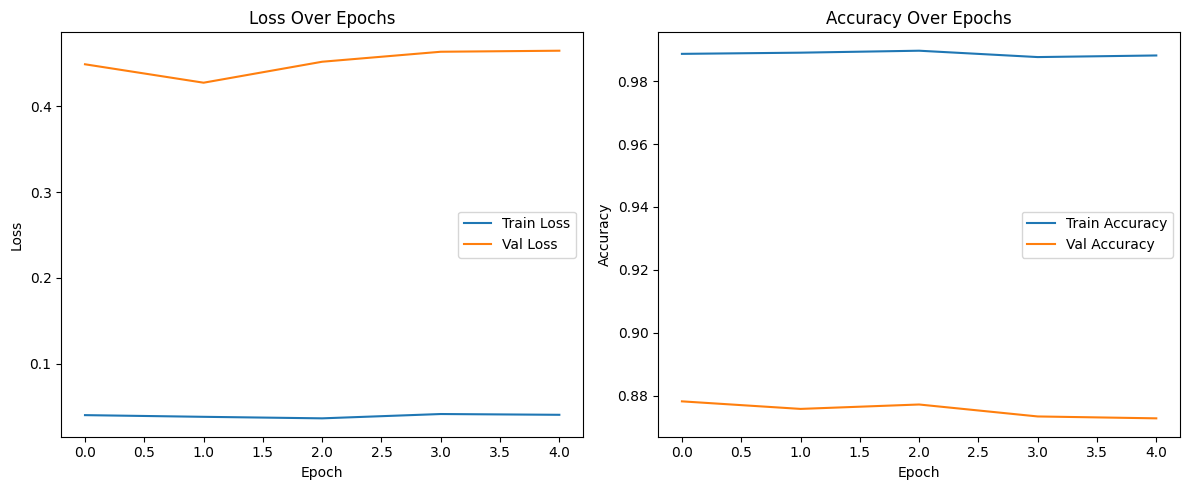

Pruned 40% : Accuracy: 87.12% | Size: 3.30 MB | Params: 864208

Applying 50% cumulative pruning:


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/10 | Train Loss: 0.0396 | Val Loss: 0.4594 | Train Acc: 0.9885 | Val Acc: 0.8760
Epoch 2/10 | Train Loss: 0.0361 | Val Loss: 0.4353 | Train Acc: 0.9898 | Val Acc: 0.8824
Epoch 3/10 | Train Loss: 0.0345 | Val Loss: 0.4645 | Train Acc: 0.9897 | Val Acc: 0.8756
Epoch 4/10 | Train Loss: 0.0345 | Val Loss: 0.4695 | Train Acc: 0.9900 | Val Acc: 0.8716
Epoch 5/10 | Train Loss: 0.0357 | Val Loss: 0.4547 | Train Acc: 0.9896 | Val Acc: 0.8742
Early stopping triggered.


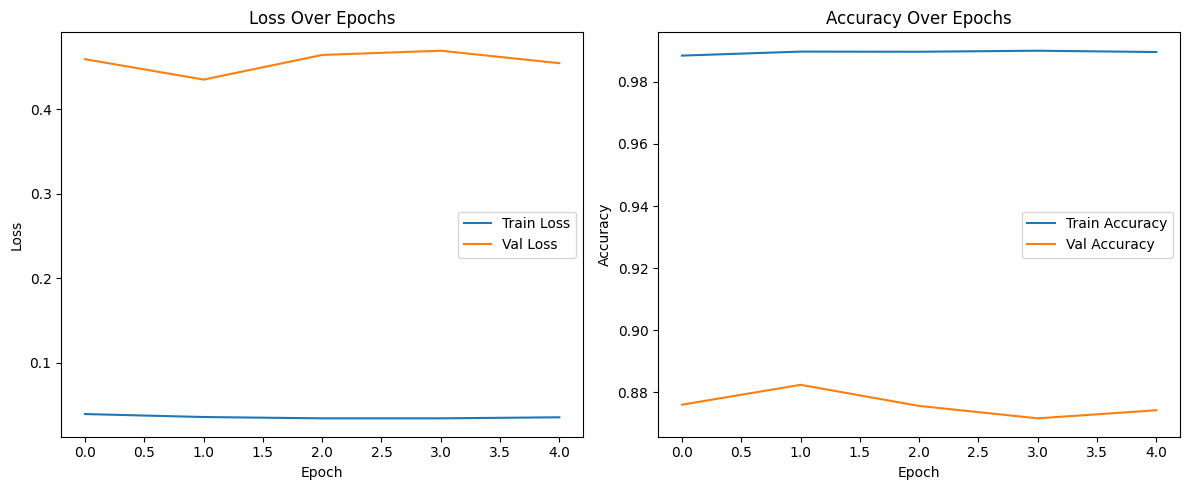

Pruned 50% : Accuracy: 87.60% | Size: 2.97 MB | Params: 777787

Applying 60% cumulative pruning:


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/10 | Train Loss: 0.0326 | Val Loss: 0.4385 | Train Acc: 0.9914 | Val Acc: 0.8758
Epoch 2/10 | Train Loss: 0.0313 | Val Loss: 0.4637 | Train Acc: 0.9918 | Val Acc: 0.8758
Epoch 3/10 | Train Loss: 0.0333 | Val Loss: 0.4895 | Train Acc: 0.9905 | Val Acc: 0.8704
Epoch 4/10 | Train Loss: 0.0351 | Val Loss: 0.4737 | Train Acc: 0.9896 | Val Acc: 0.8748
Early stopping triggered.


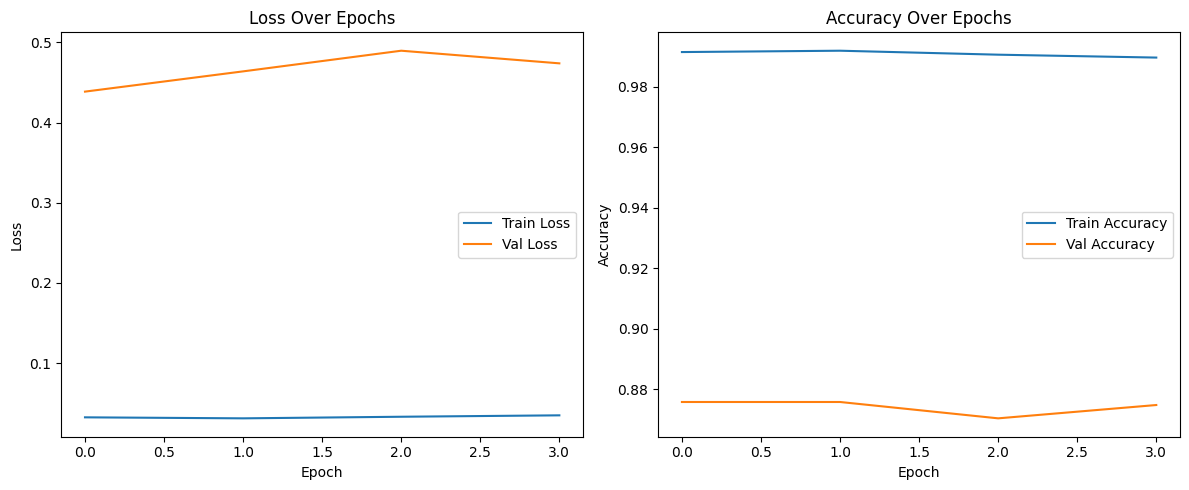

Pruned 60% : Accuracy: 86.74% | Size: 2.67 MB | Params: 700010

Applying 70% cumulative pruning:


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/10 | Train Loss: 0.0370 | Val Loss: 0.4223 | Train Acc: 0.9895 | Val Acc: 0.8854
Epoch 2/10 | Train Loss: 0.0322 | Val Loss: 0.4507 | Train Acc: 0.9912 | Val Acc: 0.8798
Epoch 3/10 | Train Loss: 0.0340 | Val Loss: 0.4556 | Train Acc: 0.9906 | Val Acc: 0.8760
Epoch 4/10 | Train Loss: 0.0334 | Val Loss: 0.4569 | Train Acc: 0.9905 | Val Acc: 0.8798
Early stopping triggered.


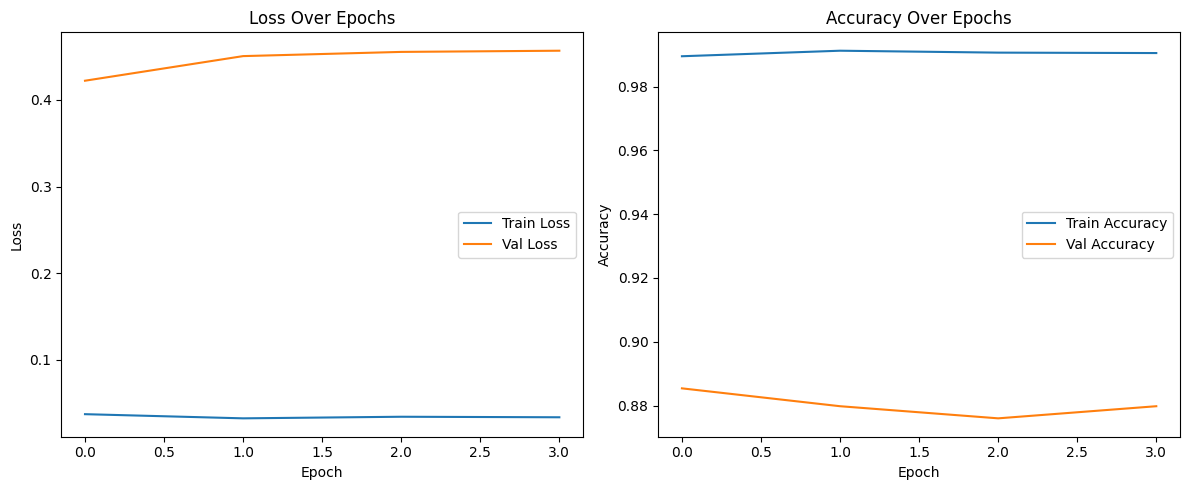

Pruned 70% : Accuracy: 86.76% | Size: 2.40 MB | Params: 630008

Applying 80% cumulative pruning:


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/10 | Train Loss: 0.0368 | Val Loss: 0.4414 | Train Acc: 0.9896 | Val Acc: 0.8784
Epoch 2/10 | Train Loss: 0.0351 | Val Loss: 0.5023 | Train Acc: 0.9900 | Val Acc: 0.8716
Epoch 3/10 | Train Loss: 0.0386 | Val Loss: 0.4908 | Train Acc: 0.9889 | Val Acc: 0.8694
Epoch 4/10 | Train Loss: 0.0358 | Val Loss: 0.4427 | Train Acc: 0.9895 | Val Acc: 0.8766
Early stopping triggered.


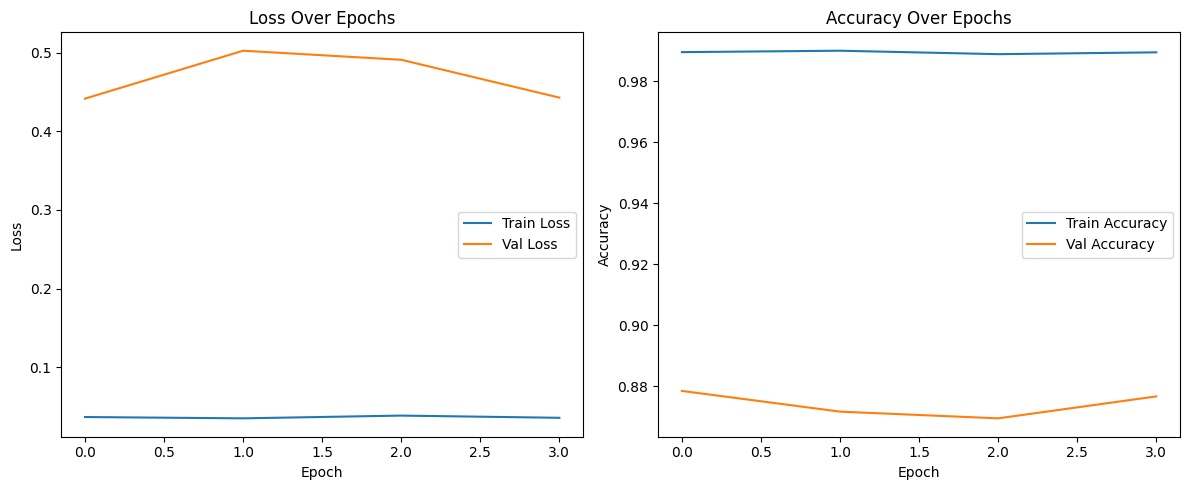

Pruned 80% : Accuracy: 87.44% | Size: 2.16 MB | Params: 567007


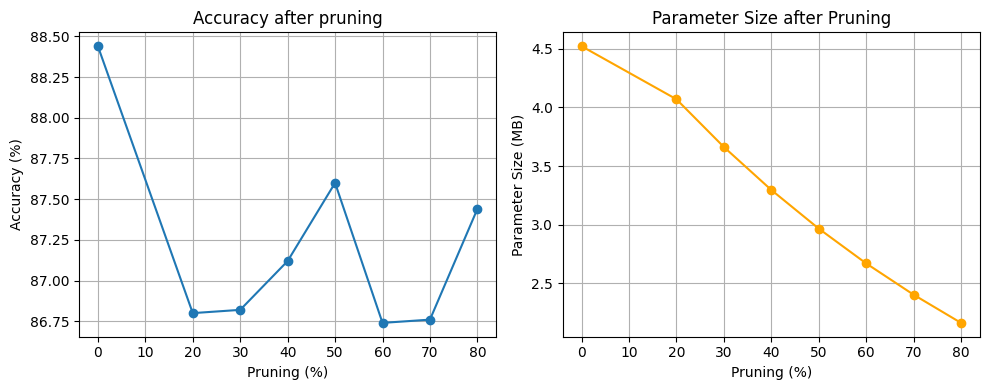

In [ ]:
accuracies = []
sizes_MB = []
nonzero_counts = []
pruning_percentages = []

pruning_steps = list(range(20, 90, 10))

initial_accuracy = evaluate(model, test_loader, device=device)
size_mb, nonzero_params = count_nonzero_param_size_step(model)

print(f"Base Model: Accuracy: {initial_accuracy * 100:.2f}% | Size: {size_mb:.2f} MB | Parameters: {nonzero_params}")
accuracies.append(initial_accuracy * 100)
sizes_MB.append(size_mb)
nonzero_counts.append(nonzero_params)
pruning_percentages.append(0)

for step in pruning_steps:
    print(f"\nApplying {step}% cumulative pruning:")
    apply_incremental_pruning(model, amount=0.1)

    model = train_model(model, train_loader, val_loader, num_epochs=10, patience=3, device=device)

    acc = evaluate(model, test_loader, device=device)
    size_mb, nonzero_params = count_nonzero_param_size_step(model)

    print(f"Pruned {step}% : Accuracy: {acc * 100:.2f}% | Size: {size_mb:.2f} MB | Params: {nonzero_params}")

    accuracies.append(acc * 100)
    sizes_MB.append(size_mb)
    nonzero_counts.append(nonzero_params)
    pruning_percentages.append(step)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(pruning_percentages, accuracies, marker='o', label='Accuracy')
plt.xlabel('Pruning (%)')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy after pruning')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(pruning_percentages, sizes_MB, marker='o', color='orange', label='Size (MB)')
plt.xlabel('Pruning (%)')
plt.ylabel('Parameter Size (MB)')
plt.title('Parameter Size after Pruning')
plt.grid(True)

plt.tight_layout()
plt.show()


## Structured pruning

### Implementation:

In [12]:
def apply_structured_pruning(model, amount, pruner, norm_type=None):
    for module in model.modules():
        if isinstance(module, (torch.nn.Conv2d, torch.nn.Linear)):
            if pruner == prune.ln_structured:
                pruner(module, name="weight", amount=amount, dim=0, n=norm_type)
            else:
                pruner(module, name="weight", amount=amount, dim=0)



Testing L1 Structured Pruning

-> Pruning 10%


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/10 | Train Loss: 0.2003 | Val Loss: 0.5016 | Train Acc: 0.9310 | Val Acc: 0.8480
Epoch 2/10 | Train Loss: 0.1526 | Val Loss: 0.4536 | Train Acc: 0.9478 | Val Acc: 0.8626
Epoch 3/10 | Train Loss: 0.1329 | Val Loss: 0.5005 | Train Acc: 0.9548 | Val Acc: 0.8494
Epoch 4/10 | Train Loss: 0.1196 | Val Loss: 0.5295 | Train Acc: 0.9601 | Val Acc: 0.8486
Epoch 5/10 | Train Loss: 0.1113 | Val Loss: 0.5433 | Train Acc: 0.9623 | Val Acc: 0.8466
Epoch 6/10 | Train Loss: 0.1060 | Val Loss: 0.5075 | Train Acc: 0.9640 | Val Acc: 0.8574
Early stopping triggered.


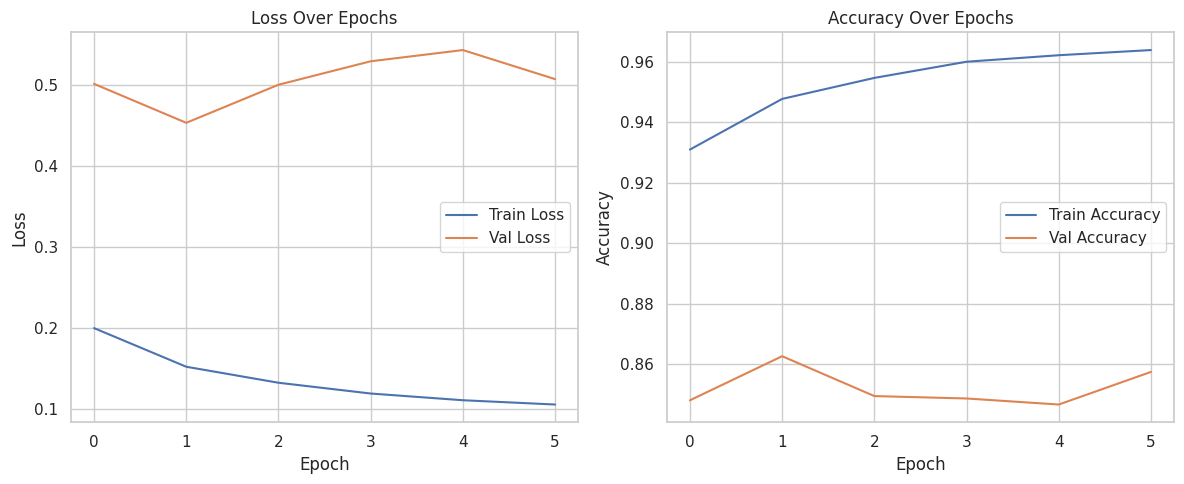

  Accuracy: 85.19%, Size: 4.06 MB

-> Pruning 20%


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/10 | Train Loss: 0.3149 | Val Loss: 0.6027 | Train Acc: 0.8403 | Val Acc: 0.7664
Epoch 2/10 | Train Loss: 0.2834 | Val Loss: 0.6203 | Train Acc: 0.8521 | Val Acc: 0.7568
Epoch 3/10 | Train Loss: 0.2743 | Val Loss: 0.6087 | Train Acc: 0.8557 | Val Acc: 0.7620
Epoch 4/10 | Train Loss: 0.2599 | Val Loss: 0.5666 | Train Acc: 0.8608 | Val Acc: 0.7736
Epoch 5/10 | Train Loss: 0.2553 | Val Loss: 0.5869 | Train Acc: 0.8616 | Val Acc: 0.7670
Epoch 6/10 | Train Loss: 0.2460 | Val Loss: 0.5843 | Train Acc: 0.8634 | Val Acc: 0.7696
Epoch 7/10 | Train Loss: 0.2435 | Val Loss: 0.5870 | Train Acc: 0.8666 | Val Acc: 0.7692
Epoch 8/10 | Train Loss: 0.2395 | Val Loss: 0.5840 | Train Acc: 0.8656 | Val Acc: 0.7702
Early stopping triggered.


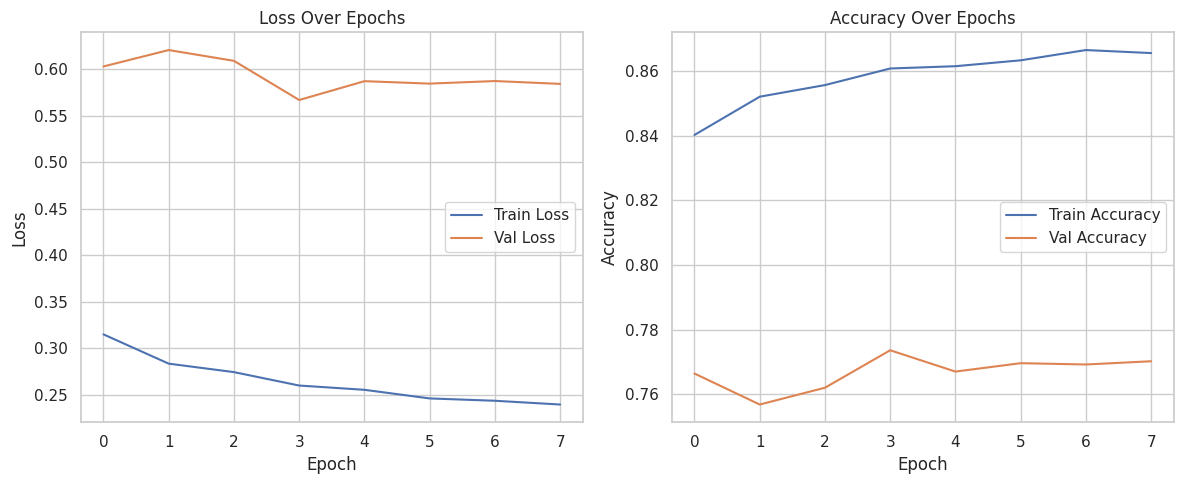

  Accuracy: 77.19%, Size: 3.61 MB

-> Pruning 30%


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/10 | Train Loss: 0.5433 | Val Loss: 0.7533 | Train Acc: 0.7292 | Val Acc: 0.6788
Epoch 2/10 | Train Loss: 0.4965 | Val Loss: 0.7443 | Train Acc: 0.7455 | Val Acc: 0.6786
Epoch 3/10 | Train Loss: 0.4765 | Val Loss: 0.7641 | Train Acc: 0.7544 | Val Acc: 0.6680
Epoch 4/10 | Train Loss: 0.4659 | Val Loss: 0.7458 | Train Acc: 0.7551 | Val Acc: 0.6710
Epoch 5/10 | Train Loss: 0.4592 | Val Loss: 0.7485 | Train Acc: 0.7596 | Val Acc: 0.6754
Epoch 6/10 | Train Loss: 0.4493 | Val Loss: 0.7548 | Train Acc: 0.7628 | Val Acc: 0.6768
Early stopping triggered.


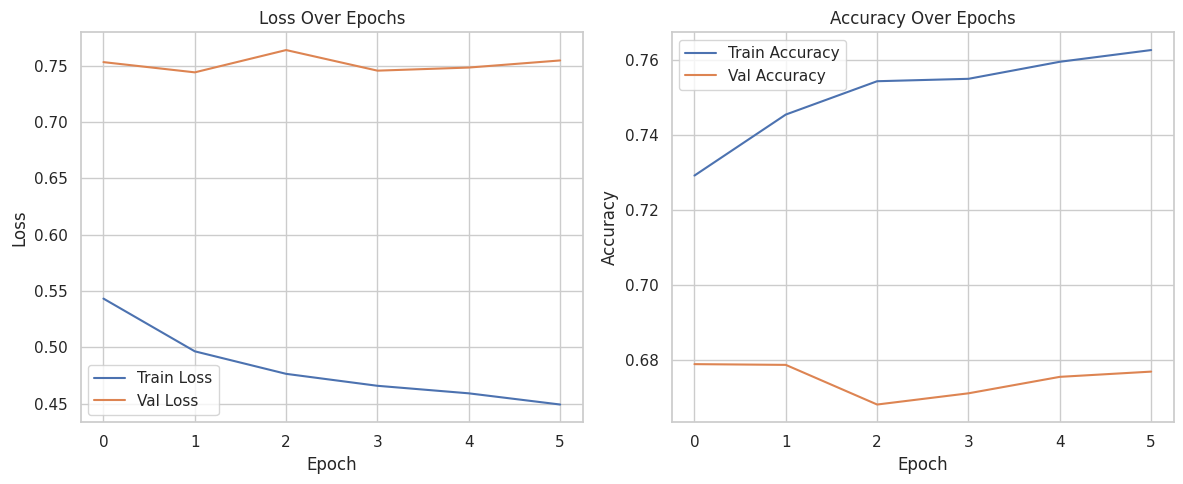

  Accuracy: 68.28%, Size: 3.15 MB

-> Pruning 40%


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/10 | Train Loss: 0.8371 | Val Loss: 1.0793 | Train Acc: 0.6108 | Val Acc: 0.5624
Epoch 2/10 | Train Loss: 0.7729 | Val Loss: 1.0092 | Train Acc: 0.6382 | Val Acc: 0.5690
Epoch 3/10 | Train Loss: 0.7529 | Val Loss: 0.9786 | Train Acc: 0.6425 | Val Acc: 0.5790
Epoch 4/10 | Train Loss: 0.7365 | Val Loss: 0.9672 | Train Acc: 0.6510 | Val Acc: 0.5854
Epoch 5/10 | Train Loss: 0.7277 | Val Loss: 0.9822 | Train Acc: 0.6514 | Val Acc: 0.5888
Epoch 6/10 | Train Loss: 0.7188 | Val Loss: 0.9726 | Train Acc: 0.6525 | Val Acc: 0.5908
Epoch 7/10 | Train Loss: 0.7134 | Val Loss: 0.9659 | Train Acc: 0.6558 | Val Acc: 0.5772
Epoch 8/10 | Train Loss: 0.7076 | Val Loss: 0.9886 | Train Acc: 0.6542 | Val Acc: 0.5840
Epoch 9/10 | Train Loss: 0.7009 | Val Loss: 1.0067 | Train Acc: 0.6605 | Val Acc: 0.5762
Epoch 10/10 | Train Loss: 0.6996 | Val Loss: 0.9734 | Train Acc: 0.6562 | Val Acc: 0.5910


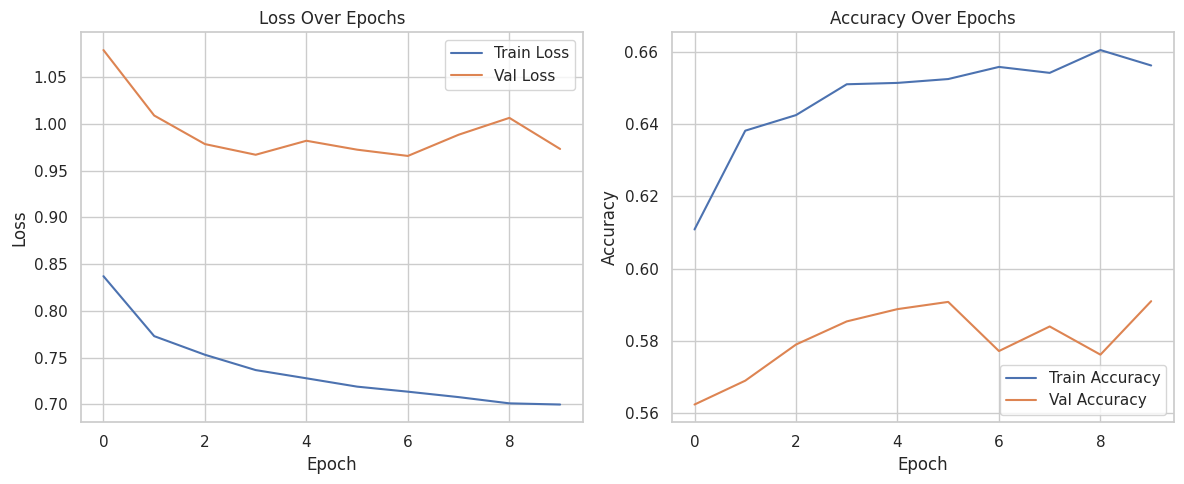

  Accuracy: 59.63%, Size: 2.70 MB

-> Pruning 50%


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/10 | Train Loss: 1.1369 | Val Loss: 1.2724 | Train Acc: 0.5238 | Val Acc: 0.4808
Epoch 2/10 | Train Loss: 1.0675 | Val Loss: 1.2267 | Train Acc: 0.5320 | Val Acc: 0.4728
Epoch 3/10 | Train Loss: 1.0459 | Val Loss: 1.2353 | Train Acc: 0.5375 | Val Acc: 0.4948
Epoch 4/10 | Train Loss: 1.0284 | Val Loss: 1.2500 | Train Acc: 0.5442 | Val Acc: 0.4922
Epoch 5/10 | Train Loss: 1.0260 | Val Loss: 1.2087 | Train Acc: 0.5473 | Val Acc: 0.5038
Epoch 6/10 | Train Loss: 1.0132 | Val Loss: 1.2504 | Train Acc: 0.5456 | Val Acc: 0.4938
Epoch 7/10 | Train Loss: 1.0062 | Val Loss: 1.2192 | Train Acc: 0.5492 | Val Acc: 0.4886
Epoch 8/10 | Train Loss: 1.0015 | Val Loss: 1.2162 | Train Acc: 0.5493 | Val Acc: 0.4920
Epoch 9/10 | Train Loss: 0.9966 | Val Loss: 1.2538 | Train Acc: 0.5548 | Val Acc: 0.4792
Early stopping triggered.


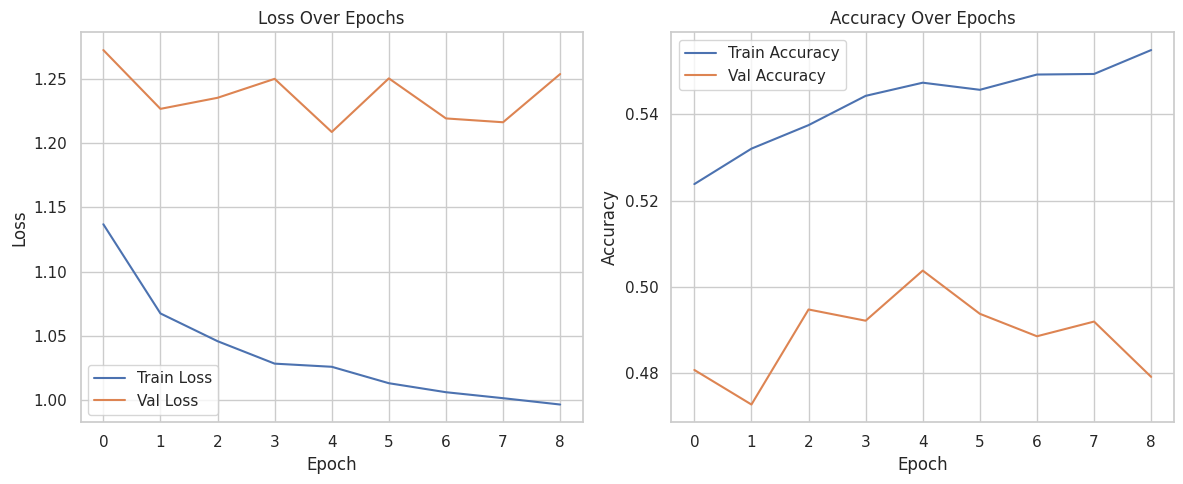

  Accuracy: 48.29%, Size: 2.24 MB

Testing L2 Structured Pruning

-> Pruning 10%


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/10 | Train Loss: 0.2045 | Val Loss: 0.5454 | Train Acc: 0.9317 | Val Acc: 0.8444
Epoch 2/10 | Train Loss: 0.1537 | Val Loss: 0.4711 | Train Acc: 0.9471 | Val Acc: 0.8500
Epoch 3/10 | Train Loss: 0.1418 | Val Loss: 0.5441 | Train Acc: 0.9507 | Val Acc: 0.8490
Epoch 4/10 | Train Loss: 0.1253 | Val Loss: 0.4897 | Train Acc: 0.9575 | Val Acc: 0.8524
Epoch 5/10 | Train Loss: 0.1090 | Val Loss: 0.4753 | Train Acc: 0.9632 | Val Acc: 0.8630
Epoch 6/10 | Train Loss: 0.1031 | Val Loss: 0.4612 | Train Acc: 0.9658 | Val Acc: 0.8628
Epoch 7/10 | Train Loss: 0.0987 | Val Loss: 0.4517 | Train Acc: 0.9664 | Val Acc: 0.8686
Epoch 8/10 | Train Loss: 0.0953 | Val Loss: 0.4575 | Train Acc: 0.9679 | Val Acc: 0.8632
Epoch 9/10 | Train Loss: 0.0883 | Val Loss: 0.4844 | Train Acc: 0.9712 | Val Acc: 0.8580
Epoch 10/10 | Train Loss: 0.0908 | Val Loss: 0.4905 | Train Acc: 0.9694 | Val Acc: 0.8600


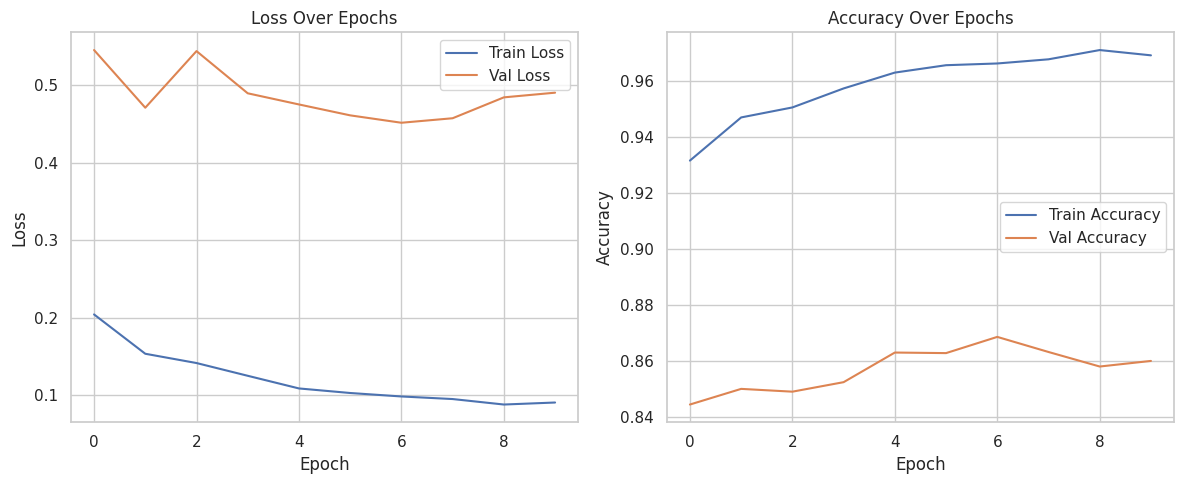

  Accuracy: 85.41%, Size: 4.06 MB

-> Pruning 20%


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/10 | Train Loss: 0.3035 | Val Loss: 0.5866 | Train Acc: 0.8442 | Val Acc: 0.7640
Epoch 2/10 | Train Loss: 0.2753 | Val Loss: 0.5751 | Train Acc: 0.8550 | Val Acc: 0.7636
Epoch 3/10 | Train Loss: 0.2604 | Val Loss: 0.5769 | Train Acc: 0.8601 | Val Acc: 0.7718
Epoch 4/10 | Train Loss: 0.2481 | Val Loss: 0.5705 | Train Acc: 0.8637 | Val Acc: 0.7746
Epoch 5/10 | Train Loss: 0.2468 | Val Loss: 0.5658 | Train Acc: 0.8644 | Val Acc: 0.7760
Epoch 6/10 | Train Loss: 0.2387 | Val Loss: 0.5578 | Train Acc: 0.8681 | Val Acc: 0.7814
Epoch 7/10 | Train Loss: 0.2319 | Val Loss: 0.6026 | Train Acc: 0.8693 | Val Acc: 0.7732
Epoch 8/10 | Train Loss: 0.2338 | Val Loss: 0.5401 | Train Acc: 0.8716 | Val Acc: 0.7796
Epoch 9/10 | Train Loss: 0.2273 | Val Loss: 0.6106 | Train Acc: 0.8717 | Val Acc: 0.7624
Epoch 10/10 | Train Loss: 0.2187 | Val Loss: 0.5570 | Train Acc: 0.8756 | Val Acc: 0.7810


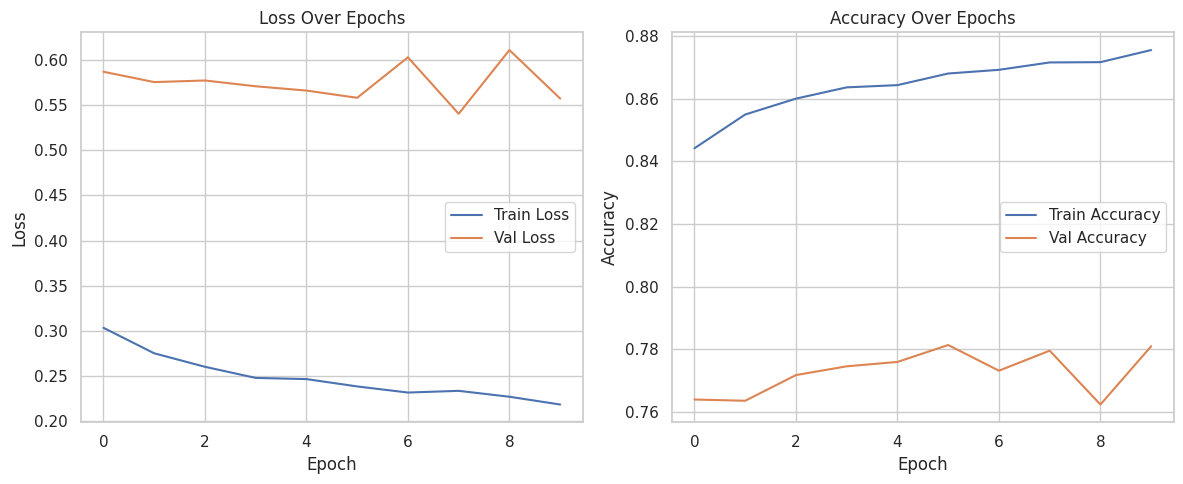

  Accuracy: 77.77%, Size: 3.61 MB

-> Pruning 30%


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/10 | Train Loss: 0.5273 | Val Loss: 0.8318 | Train Acc: 0.7346 | Val Acc: 0.6556
Epoch 2/10 | Train Loss: 0.4926 | Val Loss: 0.7760 | Train Acc: 0.7482 | Val Acc: 0.6718
Epoch 3/10 | Train Loss: 0.4707 | Val Loss: 0.8277 | Train Acc: 0.7548 | Val Acc: 0.6558
Epoch 4/10 | Train Loss: 0.4603 | Val Loss: 0.7649 | Train Acc: 0.7585 | Val Acc: 0.6736
Epoch 5/10 | Train Loss: 0.4482 | Val Loss: 0.7583 | Train Acc: 0.7610 | Val Acc: 0.6734
Epoch 6/10 | Train Loss: 0.4448 | Val Loss: 0.7781 | Train Acc: 0.7637 | Val Acc: 0.6686
Epoch 7/10 | Train Loss: 0.4355 | Val Loss: 0.7854 | Train Acc: 0.7657 | Val Acc: 0.6738
Epoch 8/10 | Train Loss: 0.4389 | Val Loss: 0.8166 | Train Acc: 0.7653 | Val Acc: 0.6690
Epoch 9/10 | Train Loss: 0.4359 | Val Loss: 0.7523 | Train Acc: 0.7647 | Val Acc: 0.6806
Epoch 10/10 | Train Loss: 0.4299 | Val Loss: 0.8034 | Train Acc: 0.7668 | Val Acc: 0.6726


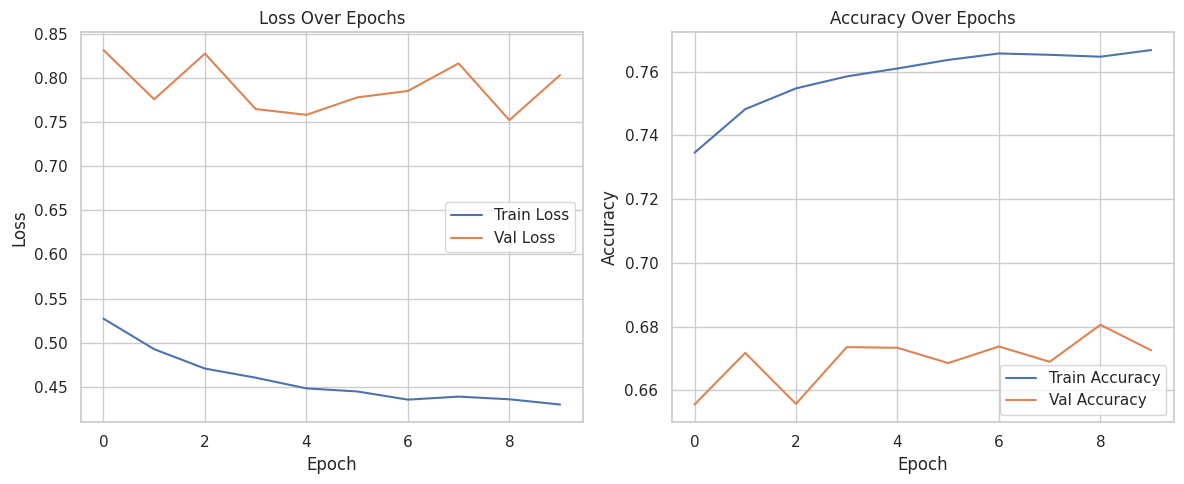

  Accuracy: 67.64%, Size: 3.15 MB

-> Pruning 40%


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/10 | Train Loss: 0.8203 | Val Loss: 1.0008 | Train Acc: 0.6162 | Val Acc: 0.5766
Epoch 2/10 | Train Loss: 0.7578 | Val Loss: 1.0033 | Train Acc: 0.6435 | Val Acc: 0.5706
Epoch 3/10 | Train Loss: 0.7384 | Val Loss: 0.9793 | Train Acc: 0.6452 | Val Acc: 0.5830
Epoch 4/10 | Train Loss: 0.7285 | Val Loss: 1.0043 | Train Acc: 0.6496 | Val Acc: 0.5620
Epoch 5/10 | Train Loss: 0.7203 | Val Loss: 0.9957 | Train Acc: 0.6512 | Val Acc: 0.5780
Epoch 6/10 | Train Loss: 0.7073 | Val Loss: 1.0317 | Train Acc: 0.6570 | Val Acc: 0.5730
Epoch 7/10 | Train Loss: 0.7076 | Val Loss: 0.9663 | Train Acc: 0.6538 | Val Acc: 0.5868
Epoch 8/10 | Train Loss: 0.6921 | Val Loss: 0.9857 | Train Acc: 0.6632 | Val Acc: 0.5696
Epoch 9/10 | Train Loss: 0.6962 | Val Loss: 0.9575 | Train Acc: 0.6552 | Val Acc: 0.5838
Epoch 10/10 | Train Loss: 0.6862 | Val Loss: 0.9699 | Train Acc: 0.6620 | Val Acc: 0.5820


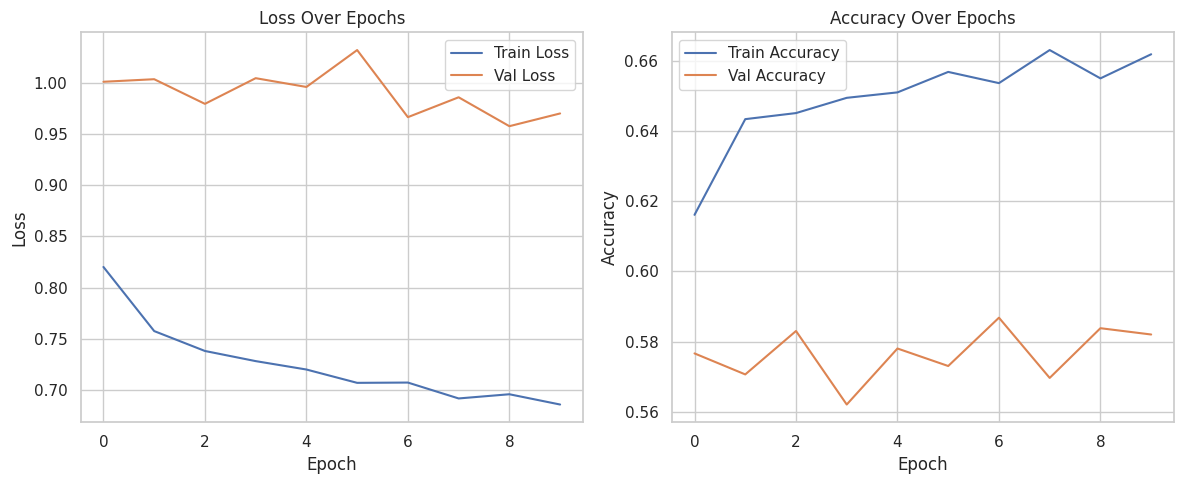

  Accuracy: 58.32%, Size: 2.70 MB

-> Pruning 50%


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/10 | Train Loss: 1.1444 | Val Loss: 1.2710 | Train Acc: 0.5157 | Val Acc: 0.4684
Epoch 2/10 | Train Loss: 1.0693 | Val Loss: 1.2452 | Train Acc: 0.5311 | Val Acc: 0.4776
Epoch 3/10 | Train Loss: 1.0510 | Val Loss: 1.2363 | Train Acc: 0.5316 | Val Acc: 0.5012
Epoch 4/10 | Train Loss: 1.0280 | Val Loss: 1.2080 | Train Acc: 0.5411 | Val Acc: 0.4956
Epoch 5/10 | Train Loss: 1.0238 | Val Loss: 1.2270 | Train Acc: 0.5468 | Val Acc: 0.5026
Epoch 6/10 | Train Loss: 1.0080 | Val Loss: 1.2192 | Train Acc: 0.5484 | Val Acc: 0.4906
Epoch 7/10 | Train Loss: 1.0017 | Val Loss: 1.2310 | Train Acc: 0.5453 | Val Acc: 0.5022
Epoch 8/10 | Train Loss: 1.0007 | Val Loss: 1.2172 | Train Acc: 0.5472 | Val Acc: 0.5002
Early stopping triggered.


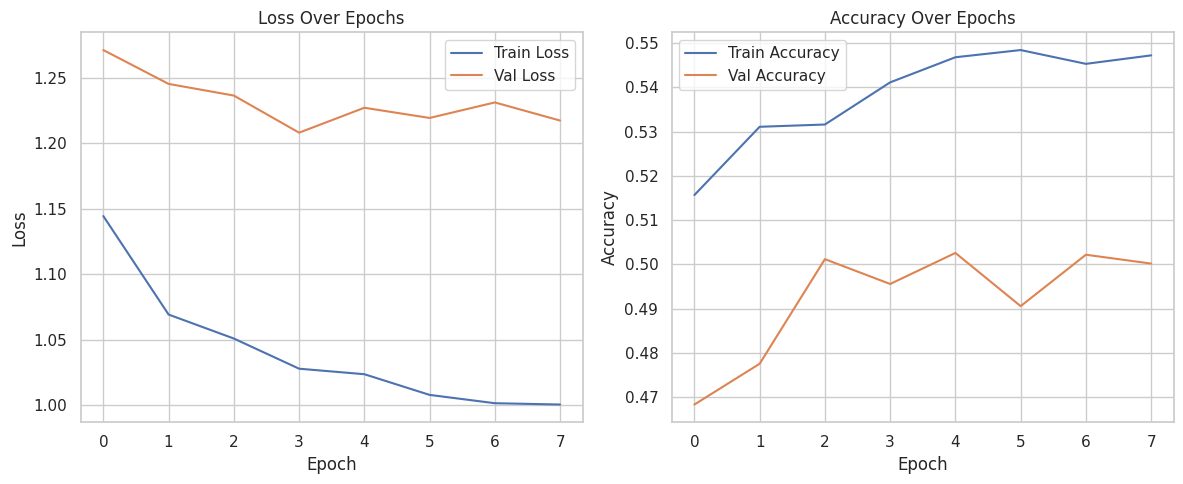

  Accuracy: 50.73%, Size: 2.24 MB

Testing Random Structured Pruning

-> Pruning 10%


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/10 | Train Loss: 0.2517 | Val Loss: 0.5108 | Train Acc: 0.9123 | Val Acc: 0.8436
Epoch 2/10 | Train Loss: 0.1869 | Val Loss: 0.5123 | Train Acc: 0.9354 | Val Acc: 0.8418
Epoch 3/10 | Train Loss: 0.1563 | Val Loss: 0.5001 | Train Acc: 0.9462 | Val Acc: 0.8494
Epoch 4/10 | Train Loss: 0.1436 | Val Loss: 0.4572 | Train Acc: 0.9509 | Val Acc: 0.8568
Epoch 5/10 | Train Loss: 0.1293 | Val Loss: 0.4531 | Train Acc: 0.9555 | Val Acc: 0.8636
Epoch 6/10 | Train Loss: 0.1235 | Val Loss: 0.4421 | Train Acc: 0.9575 | Val Acc: 0.8634
Epoch 7/10 | Train Loss: 0.1178 | Val Loss: 0.5030 | Train Acc: 0.9594 | Val Acc: 0.8524
Epoch 8/10 | Train Loss: 0.1124 | Val Loss: 0.4350 | Train Acc: 0.9614 | Val Acc: 0.8660
Epoch 9/10 | Train Loss: 0.1007 | Val Loss: 0.4768 | Train Acc: 0.9657 | Val Acc: 0.8568
Epoch 10/10 | Train Loss: 0.0920 | Val Loss: 0.4636 | Train Acc: 0.9698 | Val Acc: 0.8624


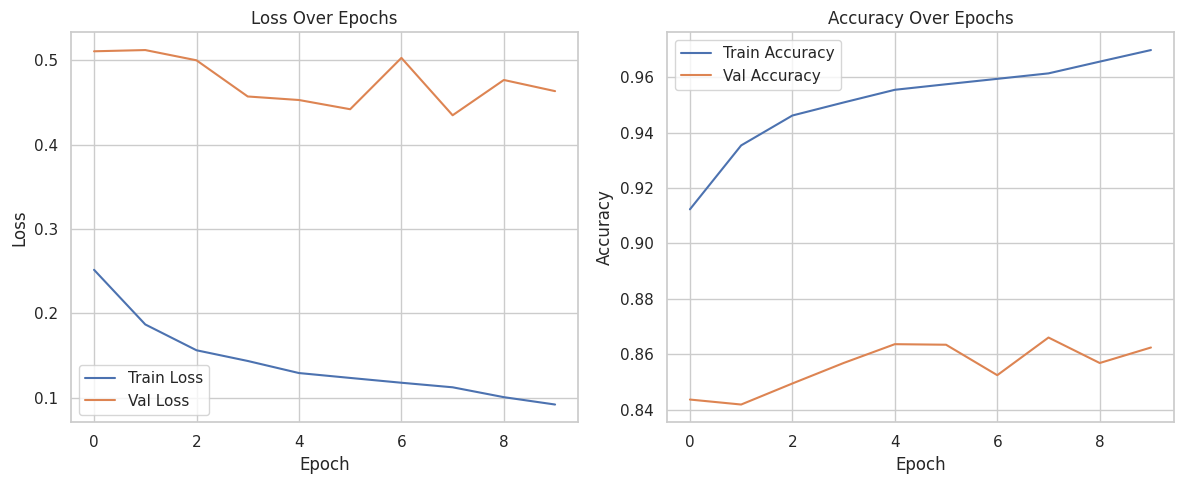

  Accuracy: 85.87%, Size: 4.06 MB

-> Pruning 20%


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/10 | Train Loss: 0.4056 | Val Loss: 0.6261 | Train Acc: 0.8165 | Val Acc: 0.7458
Epoch 2/10 | Train Loss: 0.3312 | Val Loss: 0.6190 | Train Acc: 0.8387 | Val Acc: 0.7654
Epoch 3/10 | Train Loss: 0.3144 | Val Loss: 0.6198 | Train Acc: 0.8447 | Val Acc: 0.7718
Epoch 4/10 | Train Loss: 0.2921 | Val Loss: 0.6426 | Train Acc: 0.8515 | Val Acc: 0.7626
Epoch 5/10 | Train Loss: 0.2816 | Val Loss: 0.6146 | Train Acc: 0.8566 | Val Acc: 0.7634
Epoch 6/10 | Train Loss: 0.2704 | Val Loss: 0.5802 | Train Acc: 0.8571 | Val Acc: 0.7826
Epoch 7/10 | Train Loss: 0.2668 | Val Loss: 0.6002 | Train Acc: 0.8570 | Val Acc: 0.7680
Epoch 8/10 | Train Loss: 0.2580 | Val Loss: 0.5957 | Train Acc: 0.8617 | Val Acc: 0.7822
Epoch 9/10 | Train Loss: 0.2506 | Val Loss: 0.5716 | Train Acc: 0.8655 | Val Acc: 0.7694
Epoch 10/10 | Train Loss: 0.2516 | Val Loss: 0.5951 | Train Acc: 0.8637 | Val Acc: 0.7720


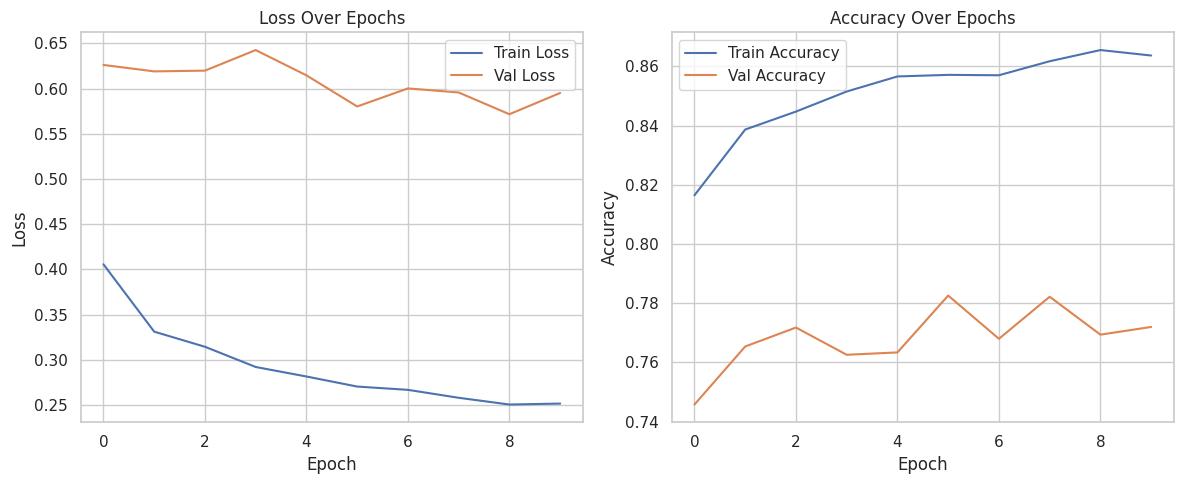

  Accuracy: 76.90%, Size: 3.61 MB

-> Pruning 30%


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/10 | Train Loss: 0.6189 | Val Loss: 0.8205 | Train Acc: 0.7085 | Val Acc: 0.6958
Epoch 2/10 | Train Loss: 0.5417 | Val Loss: 0.7891 | Train Acc: 0.7390 | Val Acc: 0.6942
Epoch 3/10 | Train Loss: 0.5178 | Val Loss: 0.7363 | Train Acc: 0.7508 | Val Acc: 0.6816
Epoch 4/10 | Train Loss: 0.5036 | Val Loss: 0.7361 | Train Acc: 0.7493 | Val Acc: 0.7120
Epoch 5/10 | Train Loss: 0.4925 | Val Loss: 0.7475 | Train Acc: 0.7535 | Val Acc: 0.7056
Epoch 6/10 | Train Loss: 0.4808 | Val Loss: 0.7929 | Train Acc: 0.7632 | Val Acc: 0.6716
Epoch 7/10 | Train Loss: 0.4794 | Val Loss: 0.7515 | Train Acc: 0.7565 | Val Acc: 0.7074
Epoch 8/10 | Train Loss: 0.4650 | Val Loss: 0.7416 | Train Acc: 0.7654 | Val Acc: 0.7122
Early stopping triggered.


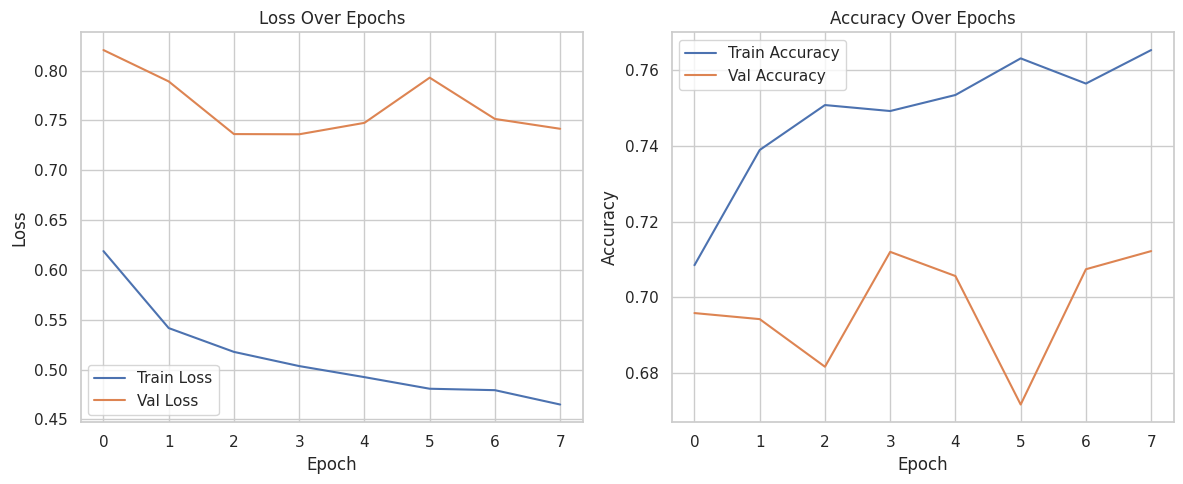

  Accuracy: 70.26%, Size: 3.15 MB

-> Pruning 40%


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/10 | Train Loss: 0.8676 | Val Loss: 0.9892 | Train Acc: 0.6191 | Val Acc: 0.5710
Epoch 2/10 | Train Loss: 0.7929 | Val Loss: 0.9985 | Train Acc: 0.6412 | Val Acc: 0.5758
Epoch 3/10 | Train Loss: 0.7752 | Val Loss: 0.9669 | Train Acc: 0.6430 | Val Acc: 0.6202
Epoch 4/10 | Train Loss: 0.7538 | Val Loss: 0.9620 | Train Acc: 0.6495 | Val Acc: 0.5850
Epoch 5/10 | Train Loss: 0.7458 | Val Loss: 0.9689 | Train Acc: 0.6528 | Val Acc: 0.6140
Epoch 6/10 | Train Loss: 0.7353 | Val Loss: 0.9602 | Train Acc: 0.6528 | Val Acc: 0.5848
Epoch 7/10 | Train Loss: 0.7267 | Val Loss: 0.9673 | Train Acc: 0.6568 | Val Acc: 0.5898
Epoch 8/10 | Train Loss: 0.7257 | Val Loss: 1.0045 | Train Acc: 0.6571 | Val Acc: 0.5850
Epoch 9/10 | Train Loss: 0.7147 | Val Loss: 1.0312 | Train Acc: 0.6592 | Val Acc: 0.5780
Epoch 10/10 | Train Loss: 0.7069 | Val Loss: 0.9621 | Train Acc: 0.6642 | Val Acc: 0.6204
Early stopping triggered.


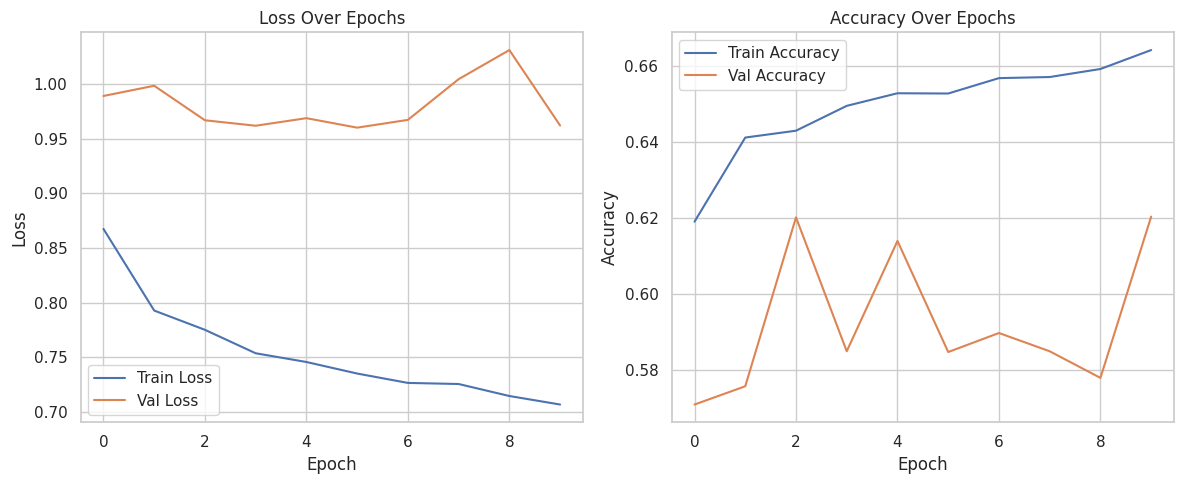

  Accuracy: 62.01%, Size: 2.70 MB

-> Pruning 50%


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/10 | Train Loss: 1.0699 | Val Loss: 1.2002 | Train Acc: 0.5385 | Val Acc: 0.5164
Epoch 2/10 | Train Loss: 1.0150 | Val Loss: 1.1245 | Train Acc: 0.5519 | Val Acc: 0.5274
Epoch 3/10 | Train Loss: 0.9999 | Val Loss: 1.1138 | Train Acc: 0.5518 | Val Acc: 0.5210
Epoch 4/10 | Train Loss: 0.9821 | Val Loss: 1.0859 | Train Acc: 0.5582 | Val Acc: 0.5332
Epoch 5/10 | Train Loss: 0.9738 | Val Loss: 1.1112 | Train Acc: 0.5614 | Val Acc: 0.5382
Epoch 6/10 | Train Loss: 0.9673 | Val Loss: 1.1154 | Train Acc: 0.5648 | Val Acc: 0.5322
Epoch 7/10 | Train Loss: 0.9627 | Val Loss: 1.1000 | Train Acc: 0.5636 | Val Acc: 0.5218
Epoch 8/10 | Train Loss: 0.9526 | Val Loss: 1.1116 | Train Acc: 0.5668 | Val Acc: 0.5238
Early stopping triggered.


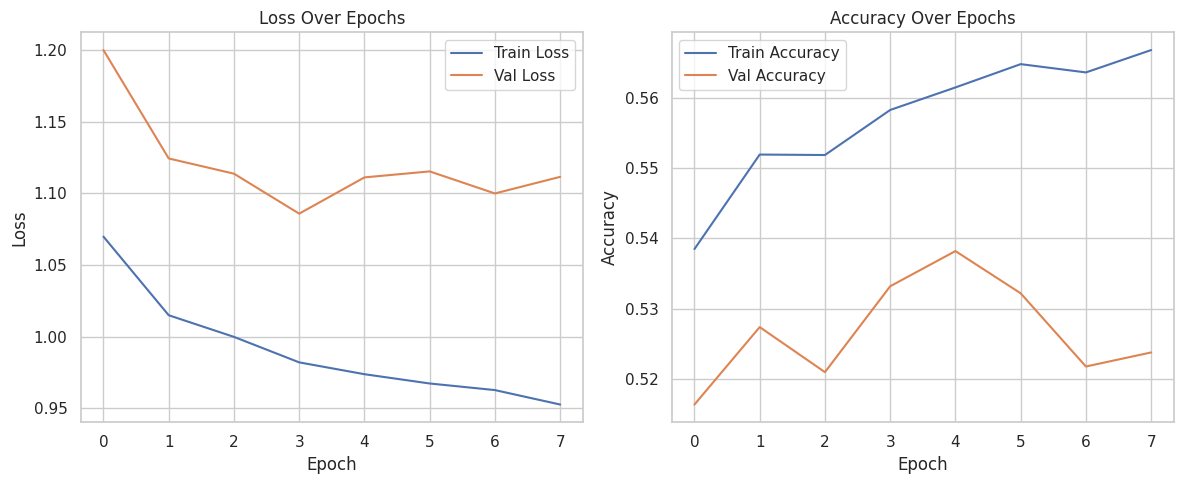

  Accuracy: 52.49%, Size: 2.24 MB


In [15]:
pruning_steps = [0.1, 0.2, 0.3, 0.4, 0.5]
structured_results = []
pruners = {
    'L1': lambda m, **kwargs: prune.ln_structured(m, **kwargs, n=1),
    'L2': lambda m, **kwargs: prune.ln_structured(m, **kwargs, n=2),
    'Random': lambda m, **kwargs: prune.random_structured(m, **kwargs),
}

for pruner_name, pruner_fn in pruners.items():
    print(f"\nTesting {pruner_name} Structured Pruning")

    model = CNNModel()
    model.load_state_dict(torch.load(base_path + "/cnn_model.pth"))
    model.to(device)

    for step, target_sparsity in enumerate(pruning_steps, start=1):
        print(f"\n-> Pruning {step * 10}%")

        prune_amount = 1/(11-step)
        if pruner_name == 'Random':
            apply_structured_pruning(model, amount=prune_amount, pruner=prune.random_structured)
        else:
            norm_type = 1 if pruner_name == 'L1' else 2
            apply_structured_pruning(model, amount=prune_amount, pruner=prune.ln_structured, norm_type=norm_type)

        model = train_model(model, train_loader, val_loader, num_epochs=10,patience=4, device=device)
        acc = evaluate(model, test_loader, device=device)
        size_mb, nonzero_params = count_nonzero_param_size_step(model)

        structured_results.append({
            'pruner': pruner_name,
            'amount': target_sparsity,
            'accuracy': acc,
            'size': size_mb,
        })

        print(f"  Accuracy: {acc*100:.2f}%, Size: {size_mb:.2f} MB")


### Results:

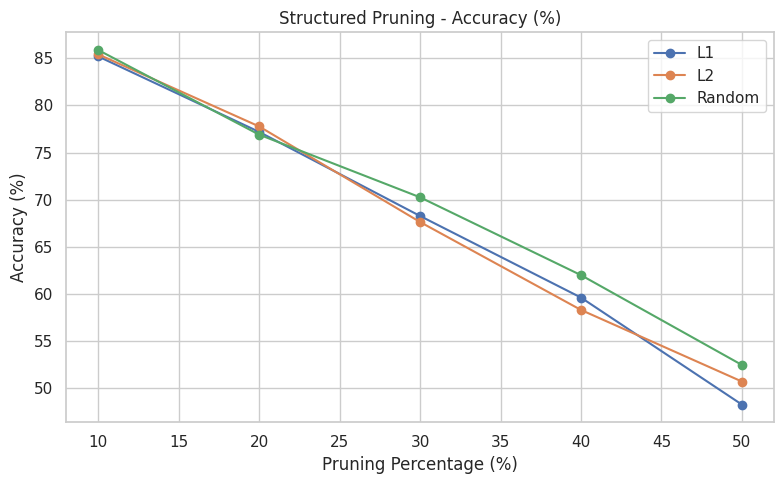

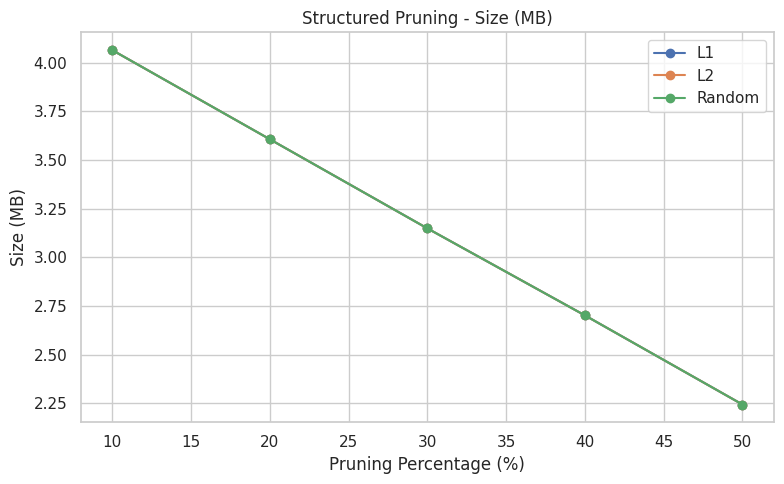

In [17]:
for metric in ['accuracy', 'size']:
    plt.figure(figsize=(8, 5))
    for pruner_name in pruners.keys():
        x = [r['amount'] * 100 for r in structured_results if r['pruner'] == pruner_name]
        y = [r[metric] * (100 if metric == 'accuracy' else 1) for r in structured_results if r['pruner'] == pruner_name]
        plt.plot(x, y, marker='o', label=pruner_name)

    plt.xlabel('Pruning Percentage (%)')
    ylabel = 'Accuracy (%)' if metric == 'accuracy' else 'Size (MB)'
    plt.ylabel(ylabel)
    plt.title(f'Structured Pruning - {ylabel}')
    plt.legend()
    plt.tight_layout()
    plt.show()
